In [1]:
from pyofss import *
from pyofss.field import get_downsampled
import numpy as np
import matplotlib as mpl
import matplotlib
import pylab as plt
plt.switch_backend('agg')

from scipy.signal import find_peaks
from scipy.interpolate import interp1d

import os.path
import pyopencl as cl
from pynvml import *

import time
import pandas as pd
%matplotlib inline

In [2]:
mpl.rcParams['agg.path.chunksize'] = 10000
font = {'family' : 'DejaVu Sans',
        'size'   : 16}

matplotlib.rc('font', **font)

## Check devices availible

In [3]:
platforms = cl.get_platforms() 
devices = [] 
for platform in platforms: 
    devices.extend(platform.get_devices()) 
device_count = len(devices) 
print(devices[0].name)
print(devices[1].name)
print(device_count) 

NVIDIA GeForce RTX 4090
NVIDIA GeForce RTX 4090
2


# Choose platform

In [4]:
platform = cl.get_platforms()[0] # get the first platform

## Define amplifier parameters

In [5]:
Tr = 54.4
lamb0 = 1566
length = 1.17*1e-3
P_sat = 0.01
small_signal_gain = 30
gamma = 3
betta_arr = [0, 0, -20.73987333818679, 0.12145449439334763, -0.00023572696512971496]

# Define process parameters

In [6]:
total_steps = 500
traces = 100
downsampling = 8000
method="ss_symmetric"

## Define pulse and domain

In [7]:
domain = Domain(bit_width=100, samples_per_bit=2**14, total_bits=1, centre_nu=lambda_to_nu(lamb0))
pulse = Sech(peak_power=16.75, width=0.7, using_fwhm=True)
field_input = pulse.generate(domain.t)
# field = add_noise(field, domain.t, -10)

# Helper functions

In [8]:
def check_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Directory: ", dir, " is created!")
        
def get_device_memory_info():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"device name {nvmlDeviceGetName(handle)}")
    print("Total memory: {} MiB".format(info.total >> 20))
    print("Free memory: {} MiB".format(info.free >> 20))
    print("Used memory: {} MiB".format(info.used >> 20))
    nvmlShutdown()

In [9]:
sys0 = System(domain, field_input)
sys0.add(Fibre(name="active_fibre", length=length, method=method, total_steps=total_steps,
            beta=betta_arr, gamma=gamma, self_steepening=False, raman_scattering=True, use_all="hollenbeck", cycle=f'cycle0', traces=traces, P_sat=P_sat, Tr = Tr, small_signal_gain = small_signal_gain, use_Er_profile=True, use_Er_noise=True, downsampling=downsampling))
start = time.time()
sys0.run()
stop = time.time()
no_cl_time = stop-start
print(f"Run time without cl is {no_cl_time} s")

Using general expression for nonlinearity
active_fibre
Run time without cl is 2.0477964878082275 s


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:248: SavingWarning: Nothing will be saved - the base fibre directory is not stated!
  warnings.warn("Nothing will be saved - the base fibre directory is not stated!", SavingWarning)


/tmp/ipykernel_3691521/2376730569.py:5: RuntimeWarning: divide by zero encountered in log10
  ax[0].plot(domain.Lambda, 10*np.log10(spectral_power(field_input, normalise=True)), c="r")


Text(0.5, 1.0, 'final')

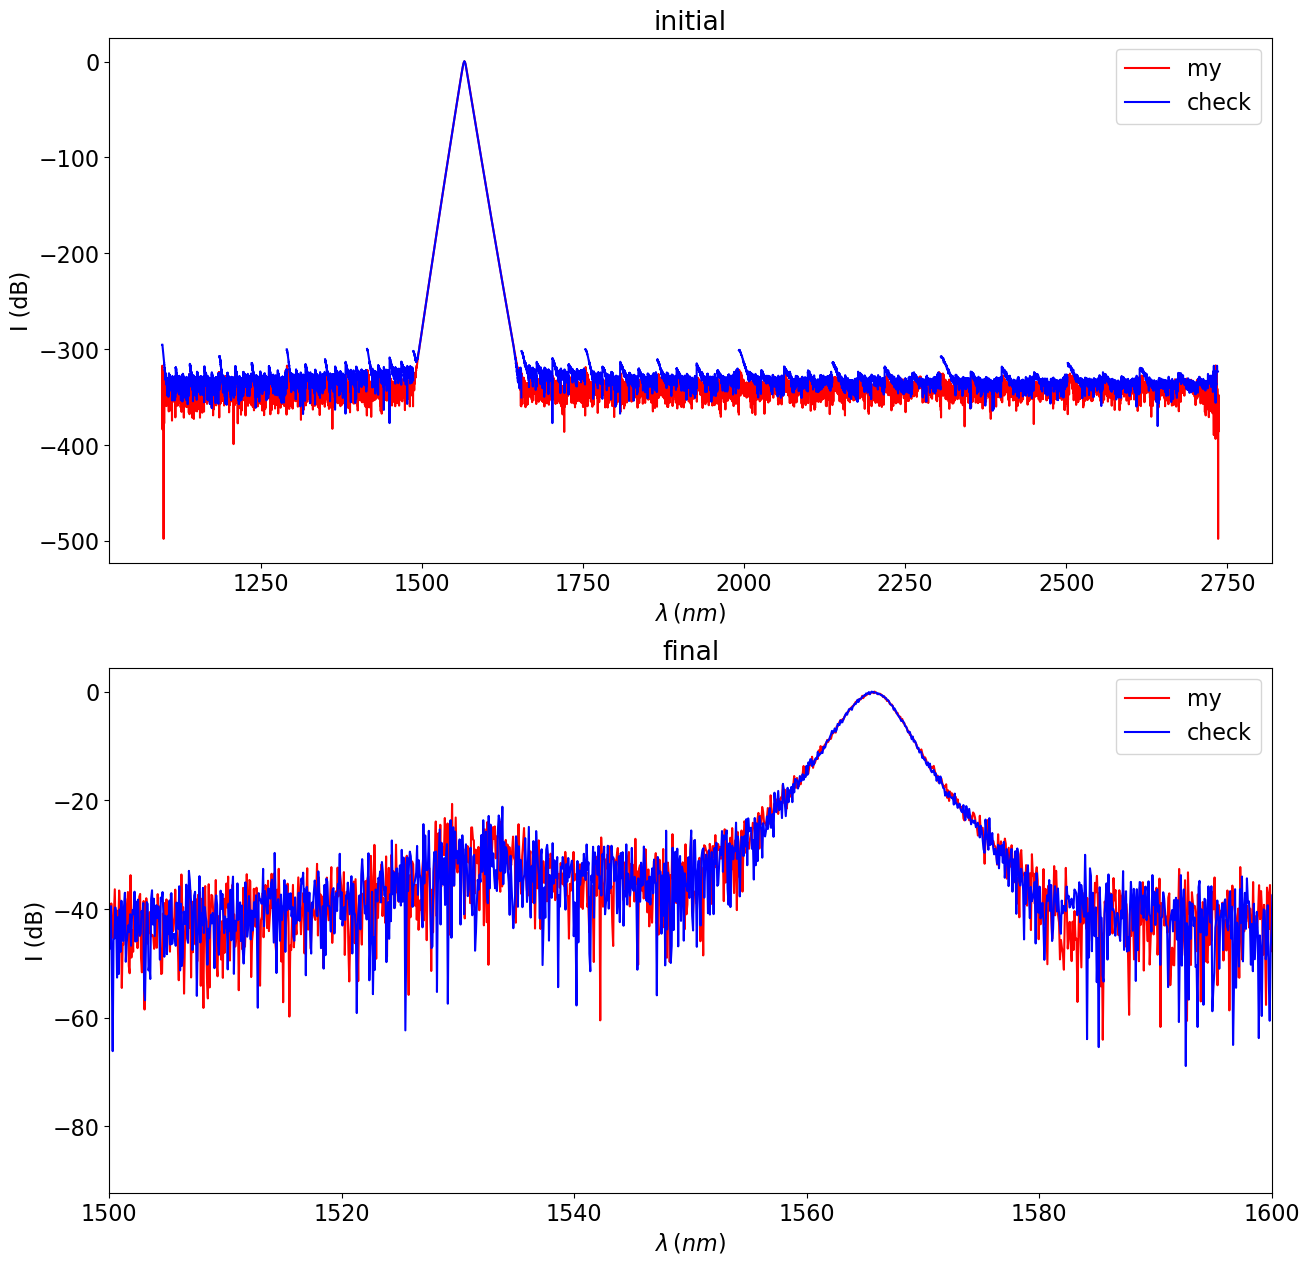

In [10]:
initial_df = pd.read_csv("compare/spectr_init_pulse.dat", delimiter="\t")
final_df = pd.read_csv("compare/spectr_fiber_117.dat", delimiter="\t")

fig, ax = plt.subplots(2, 1, figsize = (15, 15))
ax[0].plot(domain.Lambda, 10*np.log10(spectral_power(field_input, normalise=True)), c="r")
ax[0].plot(initial_df[initial_df.columns[0]], initial_df[initial_df.columns[2]]-np.amax(initial_df[initial_df.columns[2]]), c="b")

ax[1].plot(domain.Lambda, 10*np.log10(spectral_power(sys0.field, normalise=True)), c="r")
ax[1].plot(final_df[final_df.columns[0]], final_df[final_df.columns[2]]-np.amax(final_df[final_df.columns[2]]), c="b")

ax[1].set_xlim(1500, 1600)
# ax[1].set_ylim(-100, 1)

ax[0].set_ylabel(r"I (dB)")
ax[0].set_xlabel(r"$\lambda \, (nm)$")

ax[1].set_ylabel(r"I (dB)")
ax[1].set_xlabel(r"$\lambda \, (nm)$")

ax[0].legend(["my", "check"])
ax[1].legend(["my", "check"])

ax[0].set_title("initial")
ax[1].set_title("final")

(1, 1)
(1, 1)


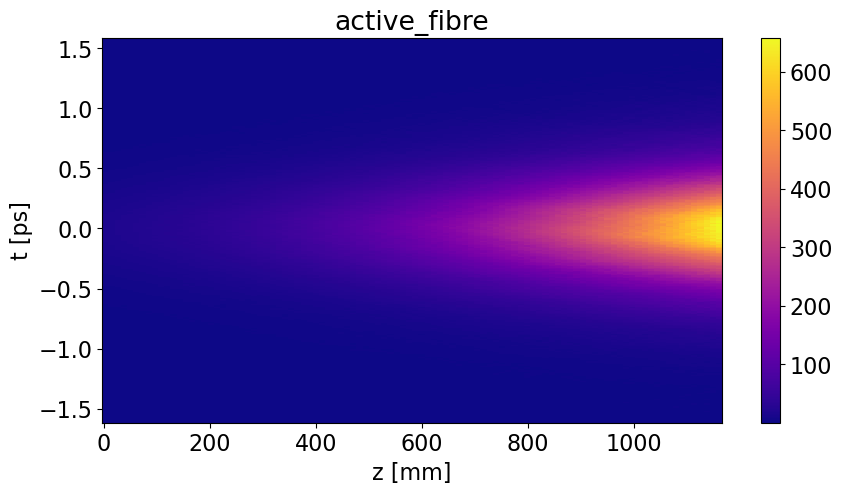

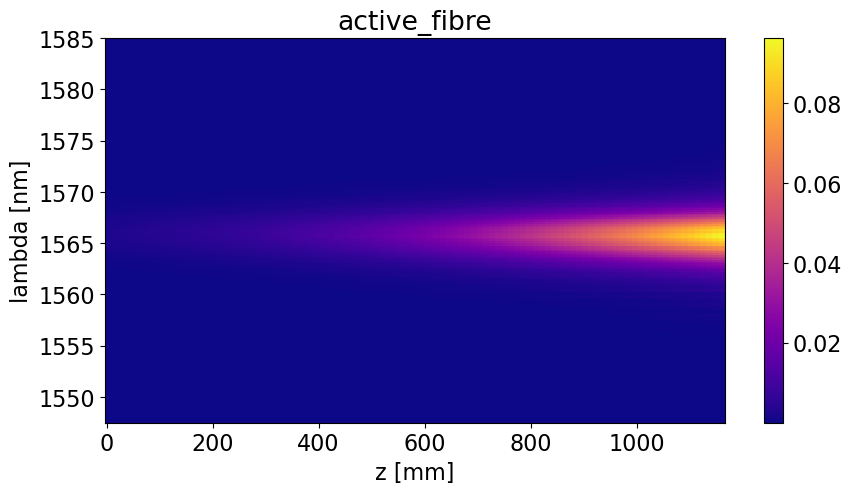

In [12]:
fig = visualise_fields_df(sys0.df_temp, get_downsampled(domain.t, downsampling=downsampling), "t [ps]", (-1, 1), True)
fig = visualise_fields_df(sys0.df_spec, get_downsampled(domain.Lambda, downsampling=downsampling), "lambda [nm]", (1500, 1600), True)

Text(0, 0.5, 'Ld/Lnl')

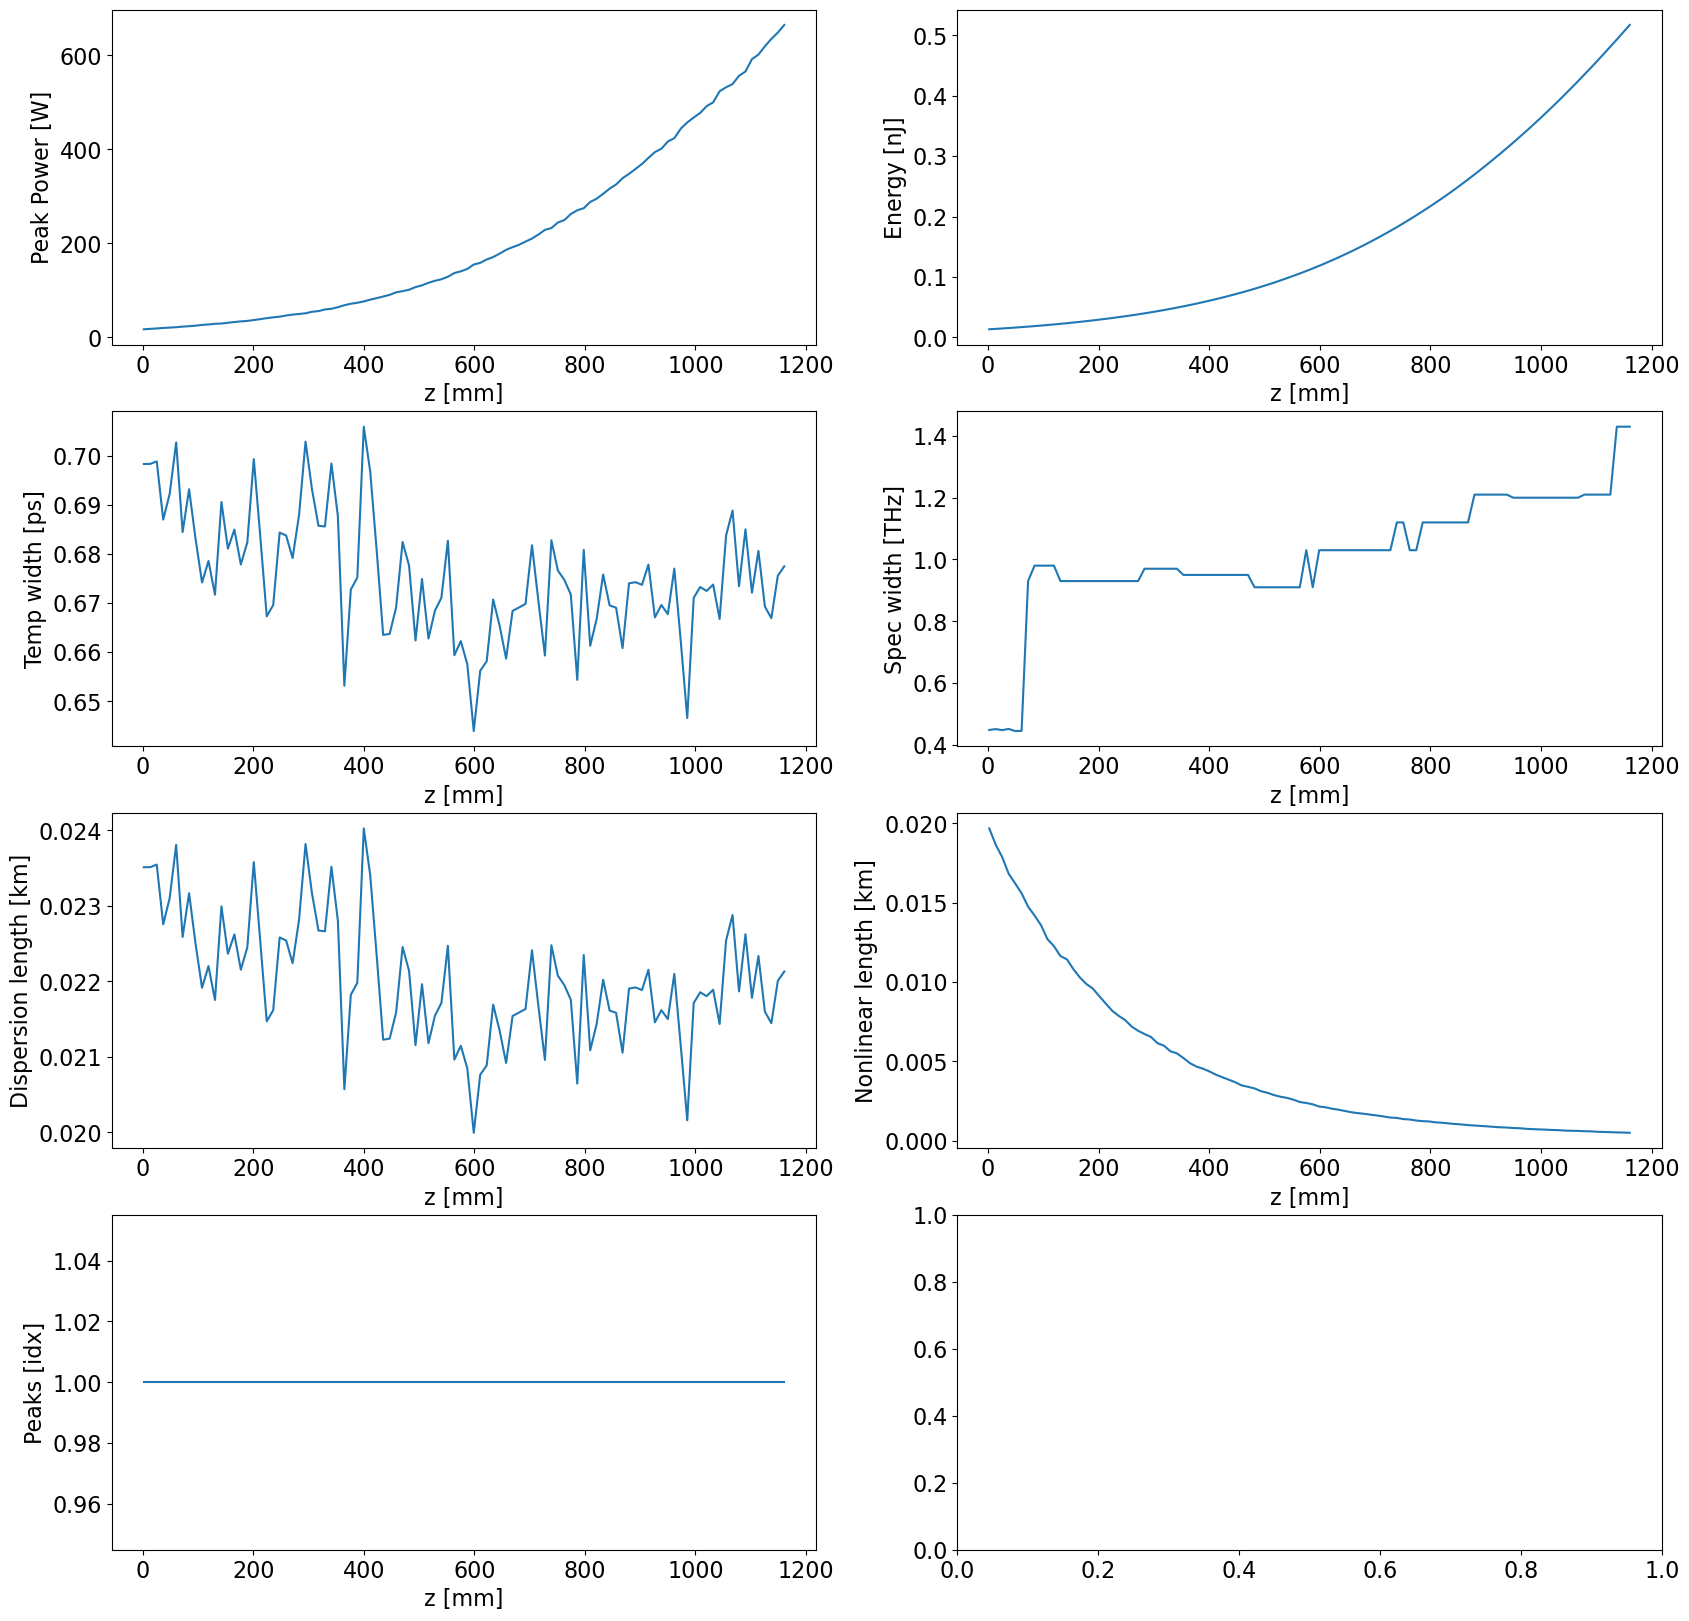

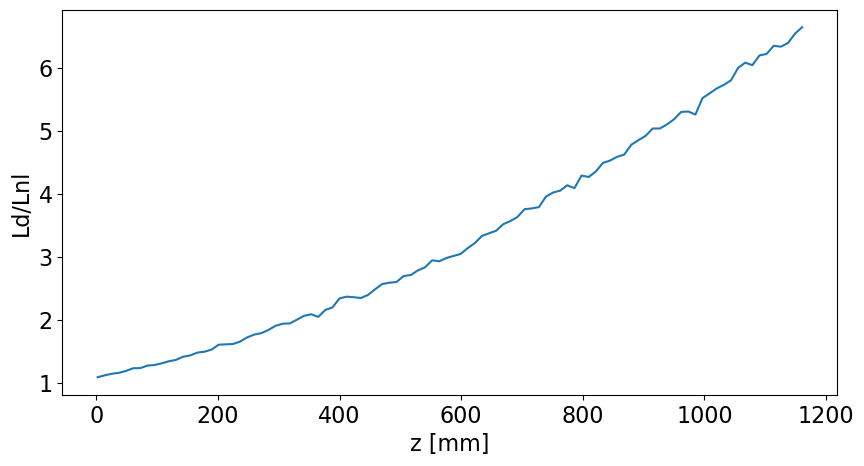

In [13]:
df_results = sys0.df_results
visualise_results_df(df_results)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

N_arr = np.sqrt(df_results['Dispersion length [km]'].values/df_results['Nonlinear length [km]'].values)
z_arr = df_results.index.get_level_values("z [mm]").values
ax.plot(z_arr, N_arr)
ax.set_xlabel(f"z [mm]")
ax.set_ylabel(f"Ld/Lnl")